# Using GRACE-FO mascon data to analyze Terrestrial Water Storage anomalies of the Colorado River Basin
## Goal: Produce a time series and map of liquid water equivalent thickness anomalies in the Colorado (CO) River Basin. ###

## Written by Dr. Felix Landerer and Munish Sikka

We demonstrate the terrestrial water storage (tws) anomalies over colorado river (CO) basin while using a shape file to crop this region from globally gridded GRACE-FO mascon data. The users can reuse this notebook tutorial to replicate the results over CO basin or apply any other desired shape file to generate map of the region and perform statistics such as time mean over the regional data for entire GRACE mission duration or a subset of time.

## References: 
1) GRACE-FO L3 Handbook: https://podaac-tools.jpl.nasa.gov/drive/files/allData/gracefo/docs/GRACE-FO_L3_Handbook_JPL.pdf
2) https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/subset-netcdf4-climate-data-spatially-aoi/
3) https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/wmobb_shp_zip.html?nn=201388 (shape file used in this code)
4)https://github.com/c-h-david/shbaam/blob/master/src/shbaam_twsa.py

In [1]:
import requests
import time
import pylab as plt

from netCDF4 import Dataset, date2index
from datetime import datetime, date

import xarray as xr
#import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.dates as mdates


from mpl_toolkits.basemap import Basemap
import shapefile
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import os


import sys
import os.path
import subprocess
import netCDF4
import numpy
import datetime
import math
import csv

import s3fs

### Establish cloud connection to read GRACE mascon dataset

In [2]:
def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds


creds = store_aws_keys()
#print(creds)

s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)
print(f"\nThe current session token expires at {creds['expiration']}.\n")

# PO.DAAC's 'short name' is an identifier for the dataset
ShortName = 'TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3'

# Ask PODAAC for the collection id using the 'short name'
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']
print(f'collection id: {ccid}')

start_time = time.time()

#ss = "podaac-ops-cumulus-protected/" + ShortName + '/GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc'

ss="podaac-ops-cumulus-protected/%s/*.nc"%ShortName
GRACE_s3_files = np.sort(s3.glob(ss))



The current session token expires at 2023-02-03 21:27:36+00:00.

collection id: C2536962485-POCLOUD


### Read the GRACE mascon data as xarray; We need to update the filename as its updated every month with additional month included.
Typical data latency is less than 60 days.

In [3]:
dataset=xr.open_dataset(s3.open('podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202207.GLO.RL06M.MSCNv02CRI.nc'))
mask_to_read= 'Colorado(Arizona)'
scale_factor_var='scale_factor'
 

output_plot_filename='Colorado_river_basin.png' 
#initialize time epoch to 1st day of 2002
time_epoch = date.toordinal(date(2002,1,1)) + 366 ;

lwe_thickness = dataset.lwe_thickness[:]  
#time = dataset.time[:]

#add time epoch to time
#time = time + time_epoch

#read scale factors (gain factors)
#scale_data=xr.open_dataset(s3.open('podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc'))
#scale_data=xr.open_dataset(s3.open('podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc'))
#scale_factor = scale_data.lwe_thickness[:]  

scale_factor_filename='GRACE_RESOURCES/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc'
scale_file=Dataset(scale_factor_filename,"r") 
scale_factor = scale_file[scale_factor_var][:]
#print array shapes
print('tws variable dim: %s' %(lwe_thickness.shape,))
print('scale_factor dim: %s' %(scale_factor.shape,)) 

#close scale file
scale_file.close()




tws variable dim: (211, 360, 720)
scale_factor dim: (360, 720)


### Read the shape file and apply scaling factors 
Selected June of 2016 as its the example used in GRACE-FO handbook, Data Use Cases (Section 7.4). 

Read the shape file and its desired layer name using shapefile.Reader and create point polygons to apply as mask on GRACE data.
Multiply the Grace dataset with scaling factors for each grid point. 

Extract from Handbook: "Gain-factors: Model-derived gain factors (also called scale factors) are provided with the data. These can be used to enhance the spatial resolution of the GRACE observations (to 0.5 degrees for mascons, and to 1 degree for harmonic-based grids). These gain factors are derived by applying GRACE processing to model estimates of terrestrial water storage and subsequently estimating the gain factor necessary to restore the amplitude of the original model estimates. Because these gain factors rely on spatial information provided by a land surface or hydrological model, caution should be used in their interpretation as these models might have biases and typically do not include groundwater or human activities in their simulations. GRACE and GRACE-FO data for groundwater studies or studies of human impacts on hydrology may require additional, customized gain factors. The appropriate use and limitations of gain factors is discussed further in Landerer and Swenson (2012) and Long et al. (2015)."

In [4]:
# select the time period for which we wish to plot the monthly data.
start_date = "2016-06-01"
end_date = "2016-06-30"
plot_title_text='June 2016 Liquid Water Equivalent Thickness'

# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360

# input shape file and region name we wish to process
sf = shapefile.Reader("GRACE_RESOURCES/wmobb_basins")
colorado='COLORADO (also COLORADO RIVER)' 

#read this region from the shape file
for shape_rec in sf.shapeRecords():
    if shape_rec.record['WMOBB_NAME'] == colorado:
        colorado_shape = shape_rec

#create point polygons from this shape file to apply as mask on GRACE dataset
vertices = []
codes = []
pts = colorado_shape.shape.points
prt = list(colorado_shape.shape.parts) + [len(pts)]
for i in range(len(prt) - 1):
    for j in range(prt[i], prt[i+1]):
        vertices.append((pts[j][0], pts[j][1]))
    codes += [Path.MOVETO]
    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
    codes += [Path.CLOSEPOLY]
clip = Path(vertices, codes)

#extract this region from GRACE dataset from desired time period. 
one_months_conus = dataset["lwe_thickness"].sel(
    time=slice(start_date, end_date))

# extract lat, lon and grid array from xarray dataset and apply scaling factor
lwe_thickness=one_months_conus.data
lwe_thickness=np.squeeze(lwe_thickness)
lwe_thickness_scaled=np.multiply(lwe_thickness,scale_factor)
lat=one_months_conus.lat
lon=one_months_conus.lon

lon, lat = np.meshgrid(lon, lat)


### Plot the map

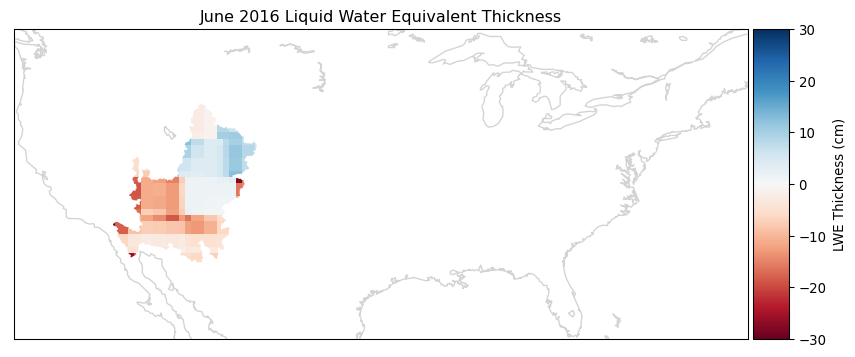

In [5]:
#plot the map of the region along with desired extent in the background
dpi = 96
fig = plt.figure(figsize=(1000 / dpi , 800 / dpi), dpi=dpi)

# Continental US (hardcoded)
min_lon = -124.73276931
min_lat = 24.95637635

max_lon = -66.96927126 
max_lat = 49.37173037    
map = Basemap(projection='cyl', llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='l')
map.drawcoastlines(color='lightgray')
ax = plt.gca()
clip_patch = PathPatch(clip, transform=ax.transData)
map.pcolormesh(lon, lat, lwe_thickness_scaled, latlon=True, cmap='RdBu', clip_on=True, clip_path=clip_patch)

plt.title(plot_title_text)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(label='LWE Thickness (cm)', cax=cax)
plt.clim(-30, 30)

plt.savefig(output_plot_filename,  dpi=dpi)

### Time Series Computation: Select time period to be read from GRACE mascon dataset for which we wish to compute monthly means. 

In [6]:
# This segment will be updated shortly
